### TODO ###
- Can add latex to raw cells in jupyter
    - E.g. captions for figures, section headings, TOC
    - Will need to add title page after exporting to tex and before converting to PDF
- Write introduction, conclusion and explanatory text for sections where not done
- Estimate time to recovery
- Complete map visualisations

In [1]:
### Imports

import pandas as pd
import numpy as np

from datetime import datetime, timedelta

import matplotlib
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter
import matplotlib.dates as mdates
import seaborn as sns
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.io import shapereader

### 1. Data manipulation and cleaning

In [2]:
### Load the data
### Best strategy seems to be using the time series representation of confirmed/died/recovered

confirmed = pd.read_csv('data/time_series_19-covid-Confirmed.csv')
deaths = pd.read_csv('data/time_series_19-covid-Deaths.csv')
recovered = pd.read_csv('data/time_series_19-covid-Recovered.csv')

populations = pd.read_csv('data/population-figures-by-country-csv_csv.csv')

country_codes = pd.read_csv('data/country_codes.csv')

Examining the structure of our data; we have a wide form table with daily reported case numbers for each country, some divided by region. Each of tables are structured in the same way.

In [3]:
confirmed.head()

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,3/10/2020,3/11/2020,3/12/2020,3/13/20,3/14/20,3/15/20,3/16/20,3/17/20,3/18/20,3/19/20
0,NaN,Thailand,15.0000,101.0000,2,3,5,7,8,8,...,53,59,70,75,82,114,147,177,212,272
1,NaN,Japan,36.0000,138.0000,2,1,2,2,4,4,...,581,639,639,701,773,839,825,878,889,924
2,NaN,Singapore,1.2833,103.8333,0,1,3,3,4,5,...,160,178,178,200,212,226,243,266,313,345
3,NaN,Nepal,28.1667,84.2500,0,0,0,1,1,1,...,1,1,1,1,1,1,1,1,1,1
4,NaN,Malaysia,2.5000,112.5000,0,0,0,3,4,4,...,129,149,149,197,238,428,566,673,790,900


In [4]:
deaths.head()

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,3/10/20,3/11/20,3/12/20,3/13/20,3/14/20,3/15/20,3/16/20,3/17/20,3/18/20,3/19/20
0,NaN,Thailand,15.0000,101.0000,0,0,0,0,0,0,...,1,1,1,1,1,1,1,1,1,1
1,NaN,Japan,36.0000,138.0000,0,0,0,0,0,0,...,10,15,16,19,22,22,27,29,29,29
2,NaN,Singapore,1.2833,103.8333,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,NaN,Nepal,28.1667,84.2500,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,NaN,Malaysia,2.5000,112.5000,0,0,0,0,0,0,...,0,0,0,0,0,0,0,2,2,2


In [5]:
recovered.head()

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,3/10/20,3/11/20,3/12/20,3/13/20,3/14/20,3/15/20,3/16/20,3/17/20,3/18/20,3/19/20
0,NaN,Thailand,15.0000,101.0000,0,0,0,0,2,2,...,33,34,34,35,35,35,35,41,42,42
1,NaN,Japan,36.0000,138.0000,0,0,0,0,1,1,...,101,118,118,118,118,118,144,144,144,150
2,NaN,Singapore,1.2833,103.8333,0,0,0,0,0,0,...,78,96,96,97,105,105,109,114,114,114
3,NaN,Nepal,28.1667,84.2500,0,0,0,0,0,0,...,1,1,1,1,1,1,1,1,1,1
4,NaN,Malaysia,2.5000,112.5000,0,0,0,0,0,0,...,24,26,26,26,35,42,42,49,60,75


At this stage, we are only interested in examining data on a country, rather than state/territory level. We can store the lat/long specified in a separate dataframe for each country. A wide format dataframe is not the best structure for analysing our data, we can transpose the DF and then convert the dates to a time series index.
<br><br>
This method is not dependent on the number of dates in the dataset and will continue to work as it is updated

In [6]:
# Pull the coordinates for each country and keep in a separate dataframe

coords = confirmed[['Country/Region', 'Lat', 'Long']].groupby('Country/Region').mean()
# A couple of colonial countries aren't amenable to aggregating their coordinates...
coords.loc['United Kingdom']['Lat'] = confirmed[confirmed['Province/State'] == 'United Kingdom']['Lat']
coords.loc['United Kingdom']['Long'] = confirmed[confirmed['Province/State'] == 'United Kingdom']['Long']
coords.loc['Netherlands']['Lat'] = confirmed[confirmed['Province/State'] == 'Netherlands']['Lat']
coords.loc['Netherlands']['Long'] = confirmed[confirmed['Province/State'] == 'Netherlands']['Long']

# Use groupby to sum the number of cases for countries that are listed with more than one territory, then drop the lat/long columns
# .T to transpose from wide to long

confirmed = confirmed.groupby('Country/Region').sum().drop(['Lat', 'Long'], axis=1).T
recovered = recovered.groupby('Country/Region').sum().drop(['Lat', 'Long'], axis=1).T
deaths = deaths.groupby('Country/Region').sum().drop(['Lat', 'Long'], axis=1).T

# Convert the indices to datetime
confirmed.index = pd.to_datetime(confirmed.index)
recovered.index = pd.to_datetime(recovered.index)
deaths.index = pd.to_datetime(deaths.index)

It is more convenient to merge this data into a single dataframe. This is done with pd.concat, creating multi-index columns. (https://pandas.pydata.org/pandas-docs/stable/user_guide/advanced.html)

In [7]:
covid_cases = pd.concat([confirmed, recovered, deaths], axis=1, keys=['confirmed', 'recovered', 'deaths']).sort_index(axis=1)

Finally, we need to deal with any missing values. As we can see below, there are currently no missing values. This may not always be the case. Given that we are dealing with time series data, interpolation is a reasonable strategy.

In [8]:
covid_cases.isna().to_numpy().sum()

0

In [9]:
# Fill up to 5 missing values between two known values

covid_cases.interpolate(method='time', axis=0, limit=5, limit_area = 'inside', inplace=True)

### 2. Descriptive analysis and initial data exploration

In [10]:
## Set the most recent date in the dataset, this will change as more dates/data is added

most_recent_date = covid_cases.index[-1]
first_date = covid_cases.index[0]

print(f"The data available on reported COVID cases extends from {first_date.date()} to {most_recent_date.date()}.")

The data available on reported COVID cases extends from 2020-01-22 to 2020-03-19.


**How many countries have reported at least 10 cases?**

In [11]:
## Select confirmed cases for all countries and the most recent date in the dateime index, this will work even when more dates are added
## Check to see if there are more than 10 cases (forms boolean series), then add them together

no_countries_over10 = (covid_cases.loc[most_recent_date]['confirmed'] > 10).sum()
total_countries = (covid_cases.loc[most_recent_date]['confirmed']).shape[0]

print(f"{no_countries_over10} countries have reported more than 10 cases out of a total of {total_countries} countries reporting data.")

110 countries have reported more than 10 cases out of a total of 155 countries reporting data.


**What are the five countries with the highest number of active cases?**

In [12]:
## Add a separate multi-indexed column for active cases for each country, this is easiest done with stack/unstack

covid_cases = covid_cases.stack()
covid_cases['active'] = np.nan
covid_cases = covid_cases.unstack()

## Calculate active cases by active = confirmed - (recovered + deaths)
covid_cases['active'] = covid_cases['confirmed'] - (covid_cases['recovered'] + covid_cases['deaths'])

In [13]:
print("The five countries with the highest number of active cases are:")
for count, i in enumerate(covid_cases.loc[most_recent_date]['active'].T.sort_values(ascending=False)[:5].iteritems()):
    print(f'{count+1}. {i[0]} with {i[1]} active cases.')

The five countries with the highest number of active cases are:
1. Italy with 33190 active cases.
2. Spain with 16026 active cases.
3. Germany with 15163 active cases.
4. US with 13477 active cases.
5. Iran with 11413 active cases.


**What is the current rate of increase in the total number of cases, based on the last week of data?**

In [14]:
# Calculate the weekly rate of change over the last week of data

week_change = covid_cases['confirmed'].iloc[-7:].sum(axis=1)[6] - covid_cases['confirmed'].iloc[-7:].sum(axis=1)[0]

print(f"In the last week of data, the number of confirmed cases has increased globally by {week_change}.")

In the last week of data, the number of confirmed cases has increased globally by 97515.


### 3. Data normalisation

We can normalise the number of cases per million population in a country, we can do this using the population data provided in the archive. 
Additionally, we can examine timing of the outbreak in various countries by counting the days since they first reached 10 confirmed cases.

In [15]:
### Add the required columns to out dataframe

covid_cases = covid_cases.stack()
covid_cases['confirmed_per_million'] = np.nan
covid_cases['recovered_per_million'] = np.nan
covid_cases['deaths_per_million'] = np.nan
covid_cases['active_per_million'] = np.nan
covid_cases['days_since_ten'] = np.nan
covid_cases = covid_cases.unstack()

In [16]:
# Not every country as their populaton reported at the same time (see eritrea in csv), although every country in the current dataset has a 2016 population recorded
# Not ever country (e.g. Cruise Ship and Holy See) have a population
# Our loop needs to be able to handle this

country_list = covid_cases['active'].columns

for i in country_list:
    
    # Calculate cases per million for each country
    try:
        code = country_codes[country_codes.Country == i]['Country_Code'].iloc[0]
        country_populations = populations[populations.Country_Code == code].T
        millions = country_populations.loc[country_populations.last_valid_index()].item() / 1000000
    except Exception as e:
        print(e)
        print("Couldn't find population for " + i + " filling with NaN")
        millions = np.nan

    covid_cases.loc[:, ('confirmed_per_million', i)] = covid_cases.loc[:, ('confirmed', i)] / millions
    covid_cases.loc[:, ('recovered_per_million', i)] = covid_cases.loc[:, ('recovered', i)] / millions
    covid_cases.loc[:, ('deaths_per_million', i)] = covid_cases.loc[:, ('deaths', i)] / millions
    covid_cases.loc[:, ('active_per_million', i)] = covid_cases.loc[:, ('active', i)] / millions
    
    # Now calculate the days since 10 confirmed cases were reported
    
    mask = covid_cases['confirmed'][i] >= 10 # Create a boolean mask
    idx = next(iter(mask.index[mask]), np.nan) # Get the index (date) of the first true value in the boolean mask
    if pd.isnull(idx):
        covid_cases.loc[:,('days_since_ten', i)] = np.nan # If a country never reached 10 cases days_since_ten = np.nan
    else:
        covid_cases.loc[:,('days_since_ten', i)] = (covid_cases['confirmed'][i].index - idx).days # Subtract the datetime index from all the dates to give us "day since"
    

None
Couldn't find population for Cruise Ship filling with NaN
None
Couldn't find population for Holy See filling with NaN


### 4. Further data exploration

**Which countries appear to be past the peak of their local outbreak?**

In [17]:
# List the countires had their highest daily active cases prior to the end date of the data

past_peak = []

for i in country_list:
    if covid_cases['active'][i][::-1].idxmax() < most_recent_date: # Find the date that the highest active cases occurred on and check if it was before the latest date
        print(i)
        past_peak.append(i)

Algeria
China
Cruise Ship
Greece
Korea, South
Nepal


We can further examine these countries visually to see which are "past the peak".

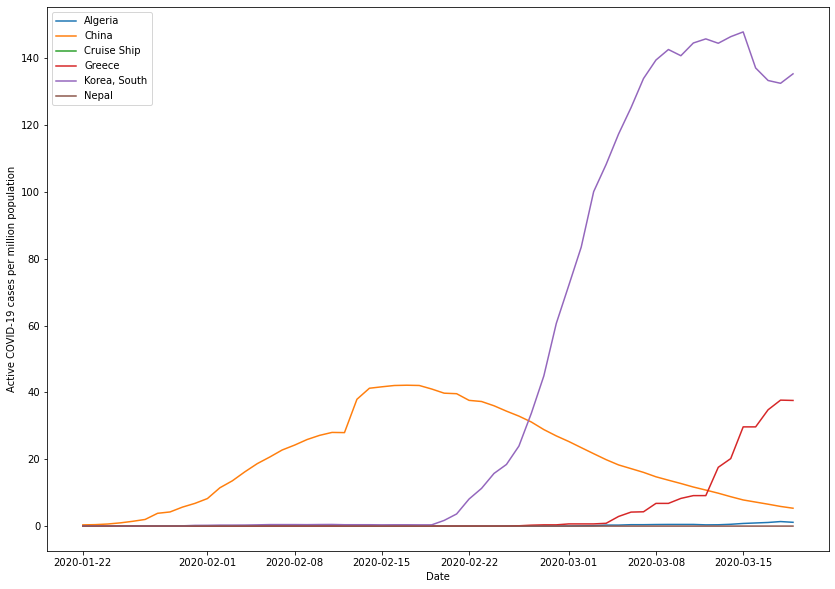

In [18]:
plt.figure(figsize=(14,10))
plt.xlabel("Date")
plt.ylabel("Active COVID-19 cases per million population")

for i in past_peak:
    plt.plot(covid_cases['active_per_million'][i], label=i)
    
plt.legend()

Following visual inspection:
- China and South Korea appear to be definitively passed their peak
- Greece may have passed their peak, but it's difficult to definitively say
- Algeria and Nepal both have small case numbers, which make it difficult to interpret the peak
- Cruise Ships are not a country

**What can you say about how long it takes for the outbreak to peak?**<br>
We can only confidently identify the peak with reasonable confidence in China, South Korea and Greece.

In [19]:
peaked = ['China', 'Korea, South', 'Greece']

days_to_peak = []

for i in peaked:
    peak_idx = covid_cases['active'][i][::-1].idxmax() 
    days_to_peak.append(covid_cases.loc[peak_idx, ('days_since_ten', i)])
    
mean_days_to_peak = np.mean(days_to_peak)
std_days_to_peak = np.std(days_to_peak)

print(f"Of the three countries to have peaked the peak occured {np.round(mean_days_to_peak, 2)} ± {np.round(std_days_to_peak, 2)} days after reaching 10 confirmed cases.")

Of the three countries to have peaked the peak occured 27.67 ± 12.71 days after reaching 10 confirmed cases.


**Based on the avilable data, can you estimate how long it takes a patient to recover? Does this vary by region or country? How confident can you be about these results?**

**Mitigation strategies are aimed at 'flattening' the outbreak, to reduce the strain on the health system. We discuss this in more detail in the concluding remarks below. For countries or regions that are far enough into their local outbreak, consider the number of active cases relative to the number of confirmed cases. Can you say anything about the effectiveness of their mitigation strategies?**

Early in the reporting of COVID-19 cases, we would expect the ratio of active cases to confirmed cases to be equal (1:1), then, as patients recover or die this ratio will gradually decline. If no new cases were identified then this ratio will eventually drop to zero. Conversely, if there is a high burden of new active cases identified this ratio will remain relatively high. Examining the change in this ratio over time may provide insights into the relative effectiveness of a countries mitigation strategies. More effective mitigation will result in a greater and more rapid reduction active cases compared to confirmed cases.
<br>
<br>
As all countries will start with an active:confirmed ratio of 1 and there is a degree of noise in the reporting of recoveries and deaths, we will examine this ratio based on a 7-day rolling average.
<br>
<br>
It is also important to examine the rate of increase in number of confirmed cases to provide context to the ratio of active to confirmed cases.

In [20]:
# Add column for active / confirmed ratio + rolling average

covid_cases = covid_cases.stack()
covid_cases['active_confirmed_ratio'] = np.nan
covid_cases['active_confirmed_ratio_7day_rolling'] = np.nan
covid_cases = covid_cases.unstack()

# Calculate the ratio of active cases per confirmed cases
covid_cases['active_confirmed_ratio'] = covid_cases['active'] / covid_cases['confirmed']
covid_cases['active_confirmed_ratio_7day_rolling'] = covid_cases['active_confirmed_ratio'].rolling(7).mean()

To attempt to gauge the effectiveness of mitigation strategies, there needs to have been enough elapsed time for them to have an impact and enough overall confirmed cases the show a reasonable effect size. Accounting for this, we have selected countries which have reported at least 30 days of data since their 10th case and have had at least 250 cases overall.

In [21]:
# Create a list of countries that have 30 days of data since 10 cases and at least 250 reported cases
at_least_30_days = []

for country in covid_cases['days_since_ten'].columns:
    if covid_cases.loc[most_recent_date, ('confirmed', country)].item() > 250:
        if covid_cases.loc[most_recent_date, ('days_since_ten', country)].item() > 30 and country != 'Cruise Ship':
            at_least_30_days.append(country)
            
print(f"There are {len(at_least_30_days)} countries with 30 days of data after their 10th case and more than 250 total cases reported.")

There are 10 countries with 30 days of data after their 10th case and more than 250 total cases reported.


We can now compare the most recent 7-day rolling average ratio of active to confirmed cases for the countries identified.

In [22]:
# Examine the change in this ratio over the 20 days since 10 cases
# As we are looking at the 7 day rolling mean, the first value will begin on day 7 following the first 10 cases

ratio_df = pd.DataFrame(index=at_least_30_days, columns = ['latest_ratio'])

for country in at_least_30_days:
    country_df = covid_cases.loc[:, (slice(None), country)].droplevel(axis=1,level=1).set_index('days_since_ten')
    most_recent_ratio = country_df['active_confirmed_ratio_7day_rolling'].iloc[-1]
    ratio_df.loc[country, 'latest_ratio'] = most_recent_ratio
    
print("\nThe three countries with the most suppression of active cases compared to confirmed cases are (by most recent 7 day average ratio only):")
for count, i in enumerate(ratio_df['latest_ratio'].sort_values(ascending=True)[:3].iteritems()):
    current = covid_cases.loc[most_recent_date, ('confirmed_per_million', i[0])]
    past_week = covid_cases.loc[(most_recent_date - timedelta(days=7)), ('confirmed_per_million', i[0])]
    change = np.round(current - past_week,2)
    print(f'{count+1}. {i[0]} with ratio of {np.round(i[1],2)} active cases to confirmed cases and an increase of {change} per million cases in the last week.')

print("\nThe three countries with the least suppression of active cases compared to confirmed cases are (by by most recent 7 day average ratio only):")
for count, i in enumerate(ratio_df['latest_ratio'].sort_values(ascending=False)[:3].iteritems()):
    current = covid_cases.loc[most_recent_date, ('confirmed_per_million', i[0])]
    past_week = covid_cases.loc[(most_recent_date - timedelta(days=7)), ('confirmed_per_million', i[0])]
    change = np.round(current - past_week,2)
    print(f'{count+1}. {i[0]} with ratio of {np.round(i[1],2)} active cases to confirmed cases and an increase of {change} per million cases in the last week.')


The three countries with the most suppression of active cases compared to confirmed cases are (by most recent 7 day average ratio only):
1. China with ratio of 0.12 active cases to confirmed cases and an increase of 0.16 per million cases in the last week.
2. Singapore with ratio of 0.57 active cases to confirmed cases and an increase of 29.78 per million cases in the last week.
3. Thailand with ratio of 0.7 active cases to confirmed cases and an increase of 2.93 per million cases in the last week.

The three countries with the least suppression of active cases compared to confirmed cases are (by by most recent 7 day average ratio only):
1. Germany with ratio of 0.99 active cases to confirmed cases and an increase of 160.18 per million cases in the last week.
2. US with ratio of 0.98 active cases to confirmed cases and an increase of 37.18 per million cases in the last week.
3. France with ratio of 0.98 active cases to confirmed cases and an increase of 129.41 per million cases in the

There appears to be a drastic differences in the degree of suppresion achieved between the countries identified, despite all being at least 30 days into their outbreak and the ratio being independent of population. Adding validity to the ratio on active:confirmed cases as a marker of outbreak suppresion, countries with a lower ratio appear to have a markedly lower rate of increase in number of cases. However, it is important to note, that a single point in time measurement may not be the most accurate representation of this measure.
<br>
<br>
To explore this further, we need to examine the trends over time visually to enable more effective comparison between countries.

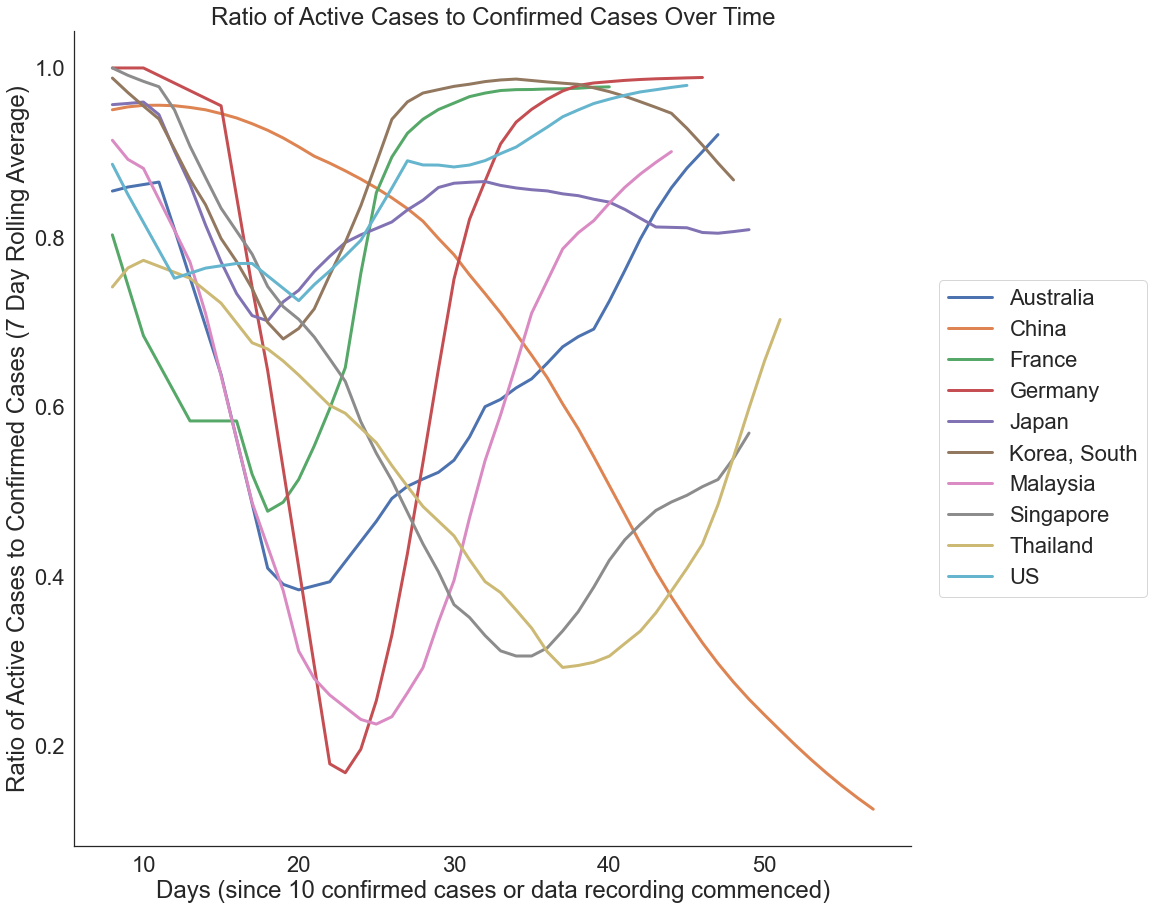

In [23]:
# Plot each country that has reported at least 30 days of data since 10 cases

sns.set(style='white')
sns.set_context('notebook', font_scale=2)

fig, ax = plt.subplots(figsize=(15,15))

for country in at_least_30_days:
    # Temporary DF of only confirmed cases per million and days since for each country
    to_plot = covid_cases.loc[:,(['active_confirmed_ratio_7day_rolling', 'days_since_ten'], country)].swaplevel(axis=1).droplevel('Country/Region', axis=1)
    # Plot only days after day 0 (10 cases)
    to_plot = to_plot[to_plot.days_since_ten > 7]
    ax.plot(to_plot['days_since_ten'], to_plot['active_confirmed_ratio_7day_rolling'], linewidth=3, label=country)

# Title and labels
ax.set_ylabel("Ratio of Active Cases to Confirmed Cases (7 Day Rolling Average)")
ax.set_xlabel("Days (since 10 confirmed cases or data recording commenced)")

ax.set_title("Ratio of Active Cases to Confirmed Cases Over Time")    

# Legend
ax.legend(ncol=1, loc='center left', bbox_to_anchor=(1.02, 0.5))

# Aesthetics
sns.despine()
    
plt.show()

Examining the visual trend in the ratio of active to confirmed cases over time provides greater insight into the trajectory of each country. While some countries have achieved good levels of suppression to date, they are now experiencing a rise in active:confirmed cases, which may indicate mitigation measures are failing (e.g. Singapore and Thailand). Other countries have achieved a more sustained and gradual downward trend in their ratio (e.g. Japan and China). A caveat to the interpretation of this data is that most countries have not yet reached their peak and as such it is difficult to comment on mitigation strategies prolonging time to peak or reducing peak magnitude. It must also be noted, that data on China's outbreak is reported well after their first 10 cases.
<br>
<br>
Overall, it appears that a lower ratio of active:confirmed cases is indicative of more effective mitigation strategies and a slower rise in confirmed COVID-19 cases.

**In epidemiology, the case fatality rate (CFR) is the ratio of deaths from a certain disease to the total number of people diagnosed with this disease. The formula is straightforward once an epidemic has ended. However, while an epidemic is still ongoing—as is the case with the COVID-19 outbreak—this formula can be misleading if, at the time of analysis, the outcome is unknown for a non-negligible proportion of patients. One alternative is to estimate CFR as deaths / (deaths + recovered). What kind of assumptions is that making? If you use this formula, what range of values do you get? Does this vary over time?**

Utilising the formula deaths / (deaths + recovered) to estimate the case fatality rate (CFR) attempts to compensate for the unknown end point of cases by using only cases that have "completed" their illness (i.e. died or recovered). 
<br><br>
There are multiple assumptions made when using this method:
1. Cases die and recover at the same rate
    - This is rarely the case. As such, if cases die faster than they recover the CFR will be overestimated. Conversely, if cases generally recover faster than they die, it will be underestimated.
2. Reporting of recoveries and deaths is consistent
    - Not all countries regularly report recovered, but most report deaths, which may overestimate the CFR
3. Definition of recovery is consistent
    - Not all countries define "recovery" in the same manner
        - Two weeks post positive PCR without hospitalisation vs repeat negative PCR testing
4. The population tested does not vary over time
    - Early in the pandemic many countries only carried out "targetted" testing of patients with risk factors or those on hospital, rather than widespread community testing. This may result in the cases being detected early in the pandemic being more severe (more likely to be hospitalised) and more likely to die. While cases detected after the commencement of widespread testing are less likely to have been detected in hospitalised patients, thus reducing the incidence of mortality.

In [24]:
# Add columns for the estimated CFR

covid_cases = covid_cases.stack()
covid_cases['cfr_estimate'] = np.nan
covid_cases = covid_cases.unstack()

# Compute the estimated CFR and add it to the DF
covid_cases['cfr_estimate'] = covid_cases['deaths'] / (covid_cases['deaths'] + covid_cases['recovered'])

To attempt to maintain a degree of robustness, we will only analyse countries that have reported at least 50 confirmed COVID-19 cases.

In [25]:
# Make a list of all countries that have more than 50 cases to date

at_least_50 = []

for country in covid_cases['confirmed'].columns:
    if covid_cases.loc[most_recent_date, ('confirmed', country)].item() > 50:
        at_least_50.append(country)

In [26]:
total_reporting = covid_cases['cfr_estimate'][at_least_50].iloc[-1].notna().sum()

print(f"As of the most recently reported data there are {total_reporting} countries with >50 confirmed cases in which the estimated CFR can be calculated.")

As of the most recently reported data there are 76 countries with >50 confirmed cases in which the estimated CFR can be calculated.


We can review the distribution of the estimated CFR (by country identified above) with summary statistics as well as visually using a histogram.

In [27]:
# Summary statistics of the estimated CFR

covid_cases['cfr_estimate'][at_least_50].iloc[-1].describe()

count    76.000000
mean      0.358562
std       0.374759
min       0.000000
25%       0.000000
50%       0.205263
75%       0.683611
max       1.000000
Name: 2020-03-19 00:00:00, dtype: float64

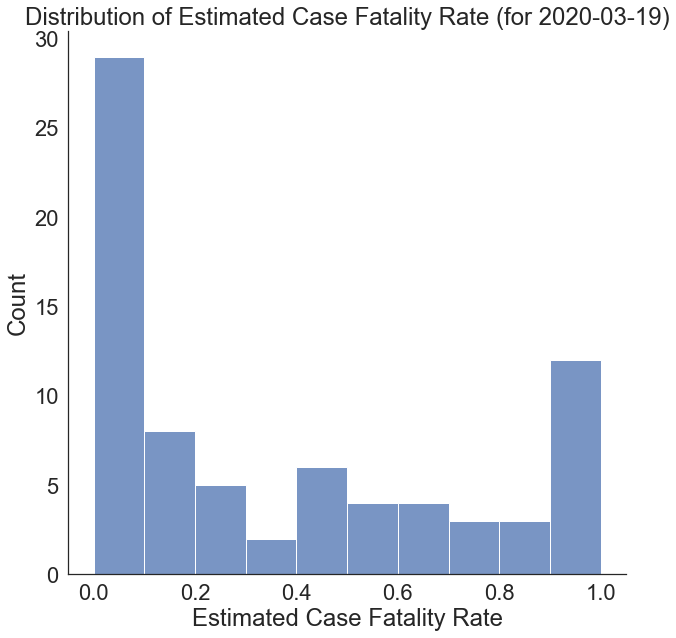

In [28]:
# Seaborn histplot of estimated CFR on the most recent date

sns.set(style='white')
sns.set_context('notebook', font_scale=2)

fig, ax = plt.subplots(figsize=(10,10))

sns.histplot(data=covid_cases['cfr_estimate'][at_least_50].iloc[-1], bins=10, ax=ax)

ax.set_xlabel("Estimated Case Fatality Rate")
ax.set_title(f"Distribution of Estimated Case Fatality Rate (for {most_recent_date.date()})")

sns.despine()

plt.show()

Examining the most recent date in the dataset provided, we can see a mean estimated CFR of 35.9% with a broad distribution and many countries reporting values of 0% or 100%. This is considerably higher than the currently reported case fatality rate, which ranges between ~0.5% and 5% globally (ref: https://coronavirus.jhu.edu/data/mortality). This is likely indicative of this method violating the first two assumptions mentioned above. Many countries have not reported any deaths compared to recoveries, while other have reported only deaths and no recoveries. In reality, this is unlikely to be the case.  This is potentially related to differing lag times in reporting recovering and deaths and potentially differing definitions for recovery reporting by country. As the data analysed is early in the global COVID-19 pandemic, a large proportion of the cases are likely to have been detected in hospitalised patients, significantly increasing their risk of mortality. To further investigate this, it is important to examine the estimated CFR over time.

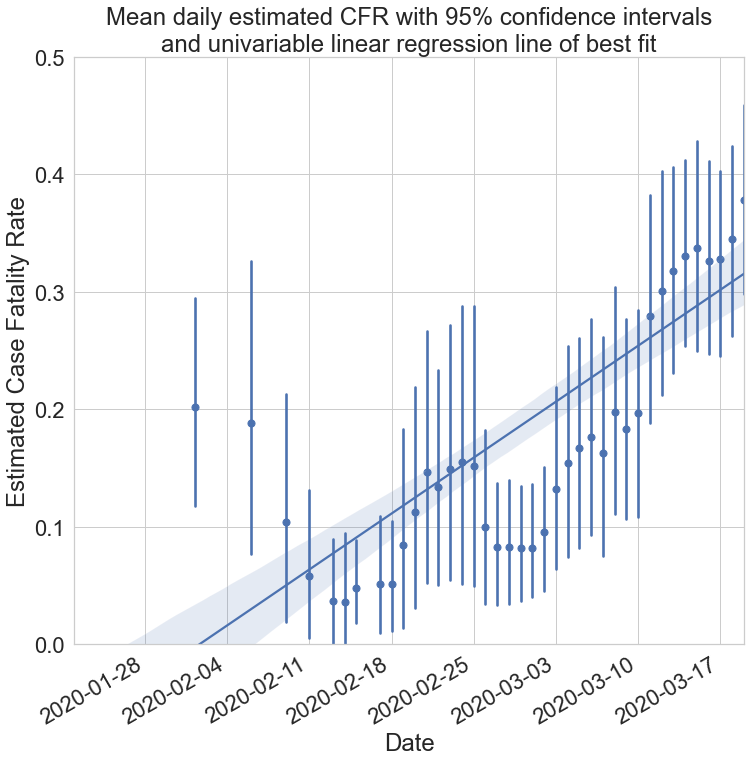

In [29]:
# Create a long form dataframe of just cfr_estimate irrespective of country and the date
cfr = covid_cases.unstack()['cfr_estimate'].droplevel(level=0).reset_index()
cfr.columns = ['date', 'cfr_estimate']

x = cfr['date']
y= cfr['cfr_estimate']

#Aesthetics
sns.set(style='whitegrid')
sns.set_context('notebook', font_scale=2)

fig, ax = plt.subplots(figsize=(12,12))
ax.xaxis.update_units(x)

#Seaborn regplot with daily bins
sns.regplot(x=ax.xaxis.convert_units(x), y=y,
            x_bins=len(x.unique()),
            x_estimator=np.mean,
            x_ci='ci',
            ci=95,
            n_boot=1000,
            truncate=True,
            ax=ax)

# Major ticks every 7 Days.
fmt_week = mdates.DayLocator(interval=7)
ax.xaxis.set_major_locator(fmt_week)

ax.set_ylim(0,0.5)

ax.set_xlabel("Date")
ax.set_ylabel("Estimated Case Fatality Rate")
ax.set_title("Mean daily estimated CFR with 95% confidence intervals\nand univariable linear regression line of best fit")

#Make the date ticks look right
fig.autofmt_xdate()

plt.show()

There is significant temporal change in the average estimated CFR, with a trend toward increase over time. Explanations for this include early reporting of deaths (out of proportion with recovered cases) and the detection of more severely unwell cases due to the early timing of the dataset.

**With a disease like COVID-19 where the vast majority of cases are mild or even asymptomatic, the number of confirmed cases is going to be highly dependent on the testing strategy. Do you see any relationship between the number of cases and your estimated CFR values?**

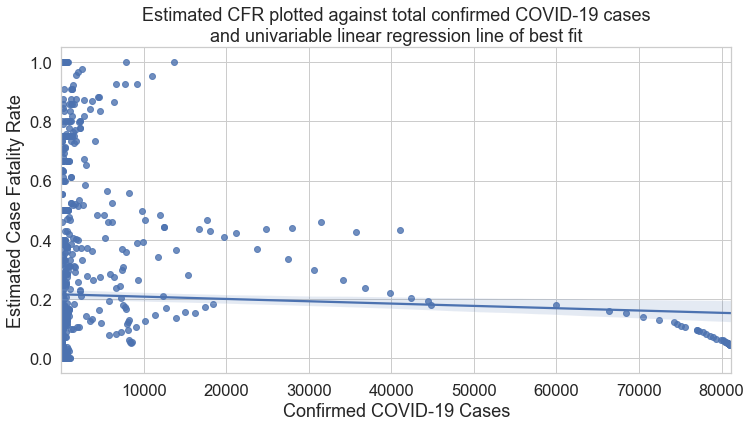

In [30]:
# Create a long format DF of confirmed COVID-19 cases to match the earlier created long formate cfr_estimate DF
confirmed = covid_cases.unstack()['confirmed'].droplevel(level=0).reset_index()
confirmed.columns = ['date', 'confirmed']

x = confirmed['confirmed']
y= cfr['cfr_estimate']

# Aesthetics
sns.set(style='whitegrid')
sns.set_context('notebook', font_scale=1.5)

fig, ax = plt.subplots(figsize=(12,6))

# Seaborn regplot
sns.regplot(x=x, y=y,
            n_boot=1000,
            truncate=True,
            ax=ax)

ax.set_xlabel("Confirmed COVID-19 Cases")
ax.set_ylabel("Estimated Case Fatality Rate")
ax.set_title("Estimated CFR plotted against total confirmed COVID-19 cases\nand univariable linear regression line of best fit")

plt.show()

Examining the plot above, we can see that with fewer total confirmed cases reported the spread of the estimated CFR is very broad. However, with increasing confirmed cases reported we see a trend toward reducing estimated CFR. This is likely due to greater detection of mild and potentially asymptomatic cases, rather than the most unwell patients who are hospitalised with COVID-19.

### 5. Data visualisation

**For countries with at least 50 confirmed cases, plot the progression of the virus starting from day 0. Be mindful of the best ways to visualise this—normalised data, linear or log scale, etc.? Also pay attention to the specific parameters you use for creating your plots (remembering that default values are rarely the best choice).**

Lots of countries have >50 cases, the resulting plot is pretty messy, but it's what they're asking for....

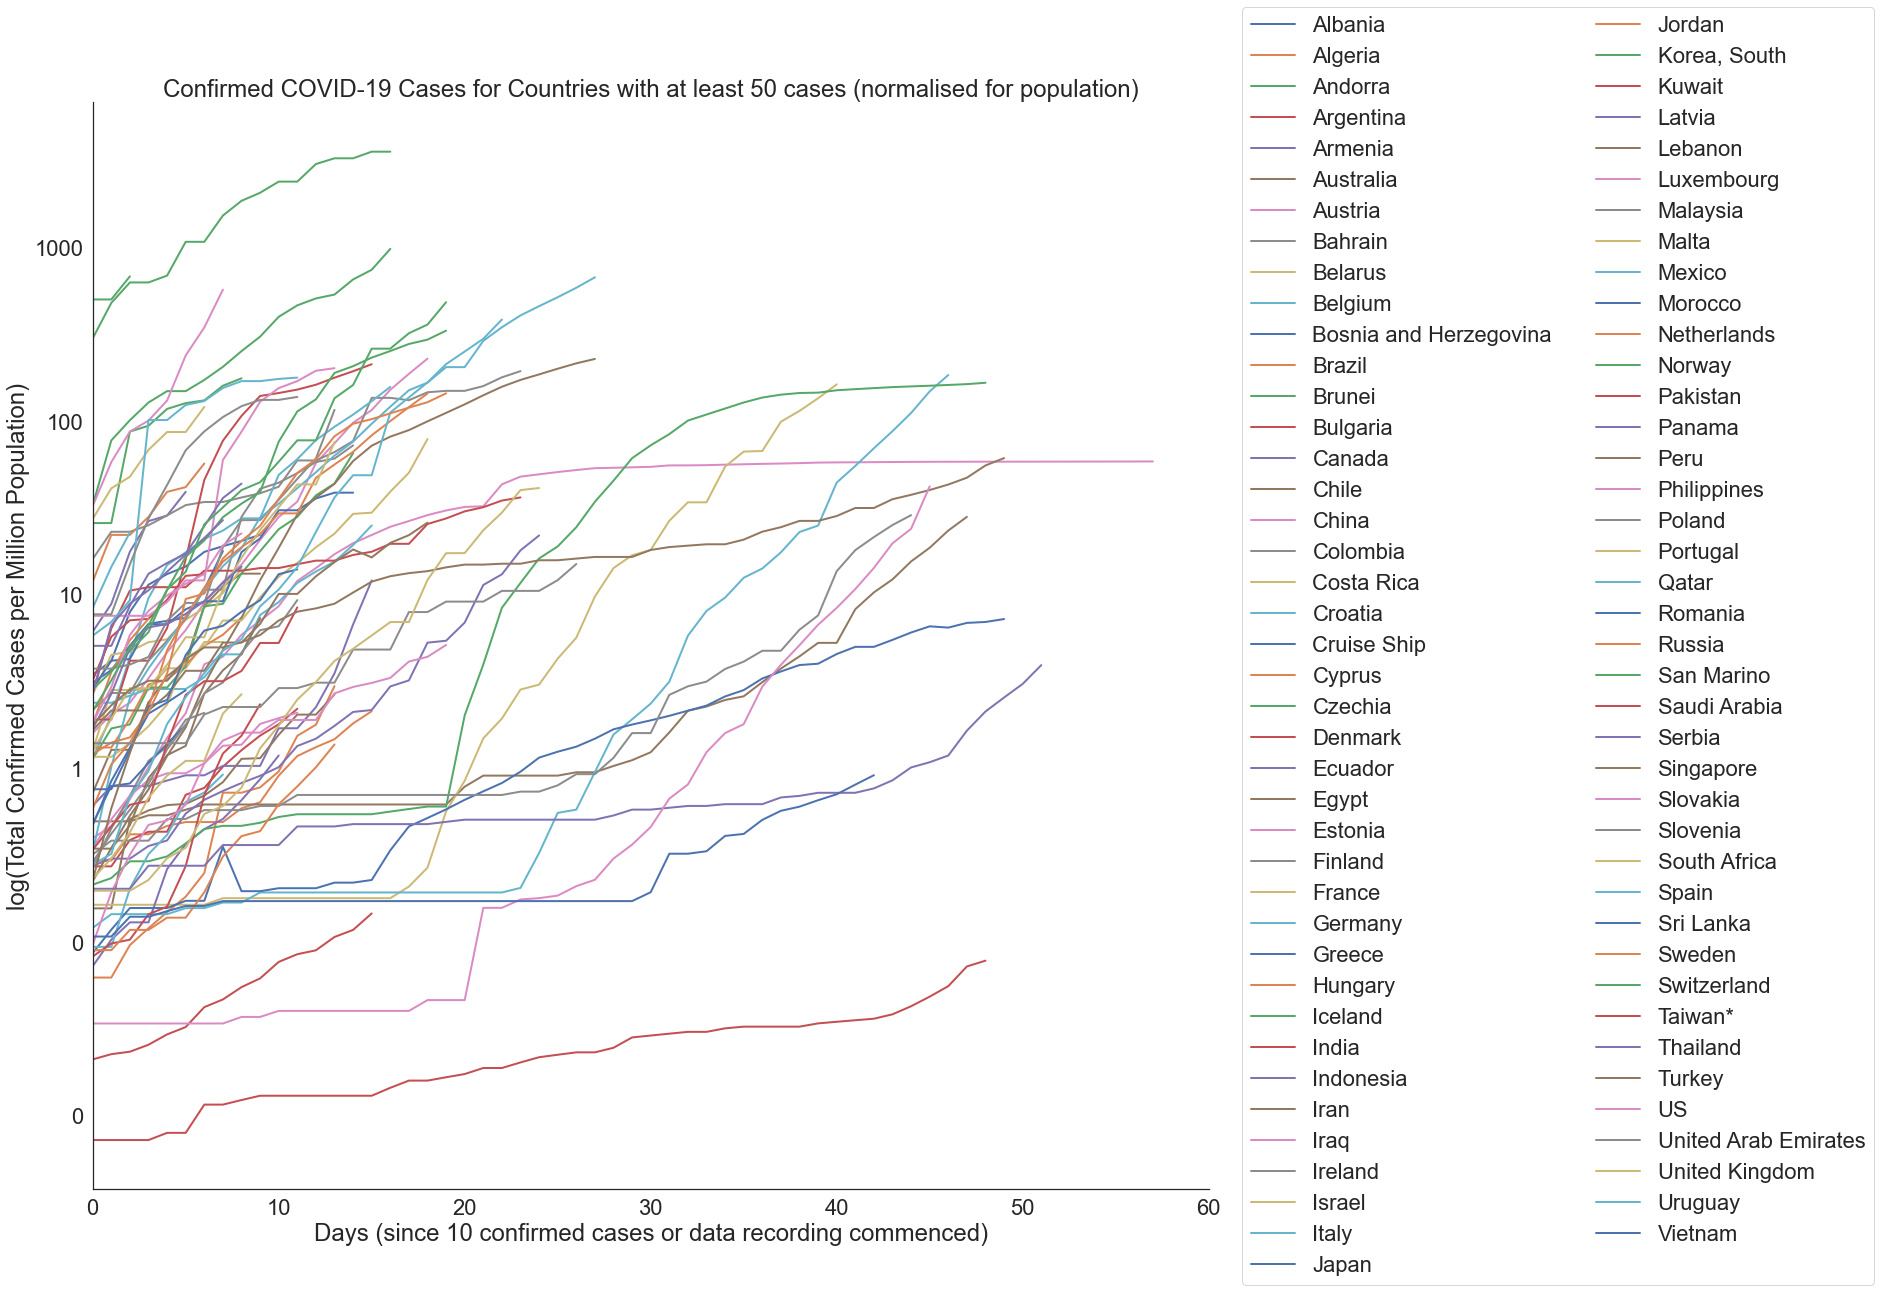

In [31]:
# Make a list of all countries that have more than 50 cases to date

at_least_50 = []

for country in covid_cases['confirmed'].columns:
    if covid_cases.loc[most_recent_date, ('confirmed', country)].item() > 50:
        at_least_50.append(country)
        
# Plot each country that has more than 50 cases to date

sns.set(style='white')
sns.set_context('notebook', font_scale=2)

fig, ax = plt.subplots(figsize=(20,20))

for country in at_least_50:
    # Temporary DF of only confirmed cases per million and days since for each country
    to_plot = covid_cases.loc[:,(['confirmed_per_million', 'days_since_ten'], country)].swaplevel(axis=1).droplevel('Country/Region', axis=1)
    # Plot only days after day 0 (10 cases)
    to_plot = to_plot[to_plot.days_since_ten >= 0]
    ax.plot(to_plot['days_since_ten'], to_plot['confirmed_per_million'], linewidth=2, label=country)

# Log scale for the y axis (makes it more interpretable between countries early in the pandemic)
ax.set_yscale('log')
ax.yaxis.set_major_formatter(ScalarFormatter())
ax.set_xlim(0,60)

# Title and labels
ax.set_ylabel("log(Total Confirmed Cases per Million Population)")
ax.set_xlabel("Days (since 10 confirmed cases or data recording commenced)")

ax.set_title("Confirmed COVID-19 Cases for Countries with at least 50 cases (normalised for population)")

# Legend
ax.legend(ncol=2, loc='center left', bbox_to_anchor=(1.02, 0.5))

# Aesthetics
sns.despine()

plt.show()

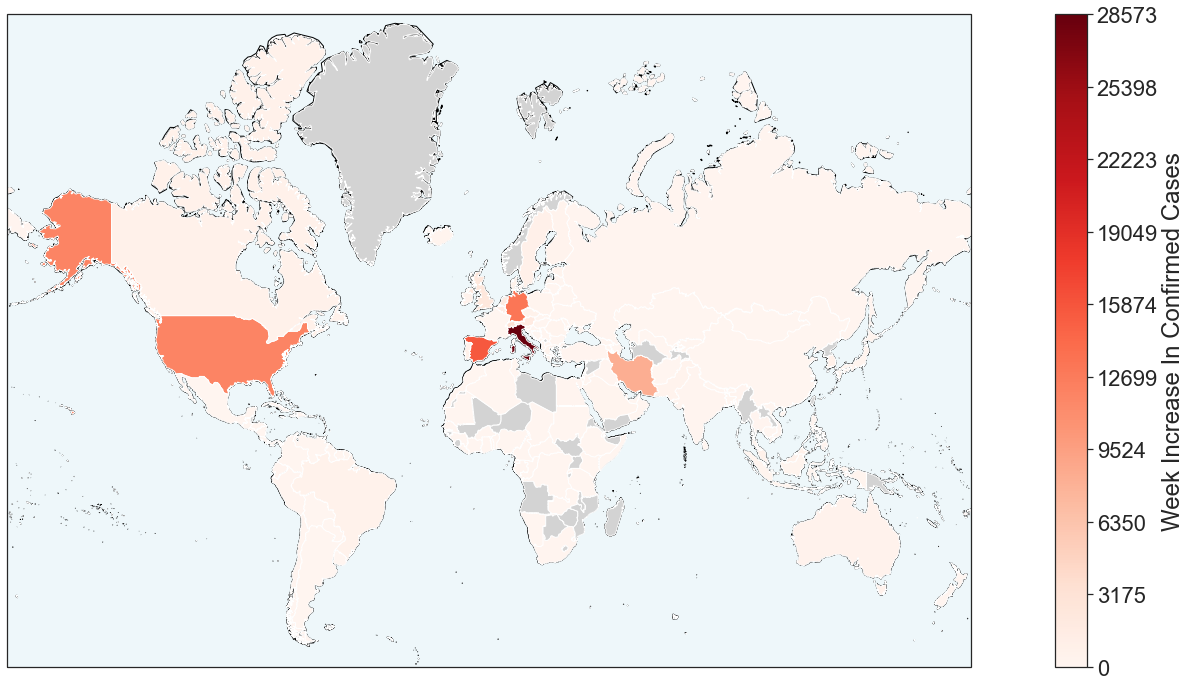

In [32]:
### https://scitools.org.uk/cartopy/docs/v0.15/examples/axes_grid_basic.html ### for map grid to utilise past 5 weeks
### Add colour patch to represent no data


fig = plt.figure(figsize=(30,12))

ax = fig.add_subplot(1, 1, 1, projection=ccrs.Mercator())
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS, linestyle=':', alpha=1)
ax.add_feature(cfeature.OCEAN, facecolor=("lightblue"), alpha=0.2)
#ax.add_feature(cfeature.LAND)
ax.coastlines(resolution='10m')
ax.set_extent([-180,180,-60,86], crs=ccrs.PlateCarree())


shpfilename = shapereader.natural_earth(resolution='50m',
                                        category='cultural',
                                        name='admin_0_countries')

reader = shapereader.Reader(shpfilename)
countries = reader.records()
#values = list(df[title].unique())

week_change = pd.DataFrame(index=country_codes.Country_Code.unique(), columns=['Country', 'week_change'])

for country in covid_cases['confirmed'].columns:
    code = country_codes[country_codes.Country == country].Country_Code.iloc[0]
    week_end = most_recent_date
    week_start = most_recent_date - timedelta(days=7)
    week_end_confirmed = covid_cases.loc[week_end, ('confirmed', country)].item()
    week_start_confirmed = covid_cases.loc[week_start, ('confirmed', country)].item()
    week_change.loc[code, 'week_change'] = (week_end_confirmed - week_start_confirmed)

week_change['week_change_norm'] = (week_change.week_change - np.nanmin(week_change.week_change))/(np.nanmax(week_change.week_change) - np.nanmin(week_change.week_change))
    
# Choose your colourmap here
cmap = matplotlib.cm.get_cmap('Reds')
    
    
#mini, maxi = min(week_change.week_change), max(week_change.week_change)
#norm=plt.Normalize(mini,maxi)

for country in countries:
    if country_codes.Country_Code.str.contains(country.attributes['ISO_A3_EH']).any():
        code = country.attributes['ISO_A3_EH']
        #print(code)
        if pd.notna(week_change.loc[code, 'week_change']):
            rgba = cmap(week_change.loc[code,'week_change_norm'])
            ax.add_geometries([country.geometry], ccrs.PlateCarree(), facecolor=rgba
                             )
        else: # If null value in week change then fill country with gray
            ax.add_geometries([country.geometry], ccrs.PlateCarree(), facecolor='lightgrey')
    else: # If no matching country code then fill country with gray
        ax.add_geometries([country.geometry], ccrs.PlateCarree(), facecolor='lightgrey')

# Add colourbar scaled to range of cases for the week
sm = plt.cm.ScalarMappable(cmap='Reds', norm=plt.Normalize(vmin=np.nanmin(week_change.week_change), vmax=np.nanmax(week_change.week_change)))
cb = plt.colorbar(sm, label='Week Increase In Confirmed Cases')
cb.set_ticks(np.linspace(np.nanmin(week_change.week_change), np.nanmax(week_change.week_change), 10))

data_crs = ccrs.PlateCarree()

**Optional: For each of the last five weeks, create a global map showing the rate of increase in the number of confirmed cases over that week. Create similar maps for the rate of increase in the number of active cases.**

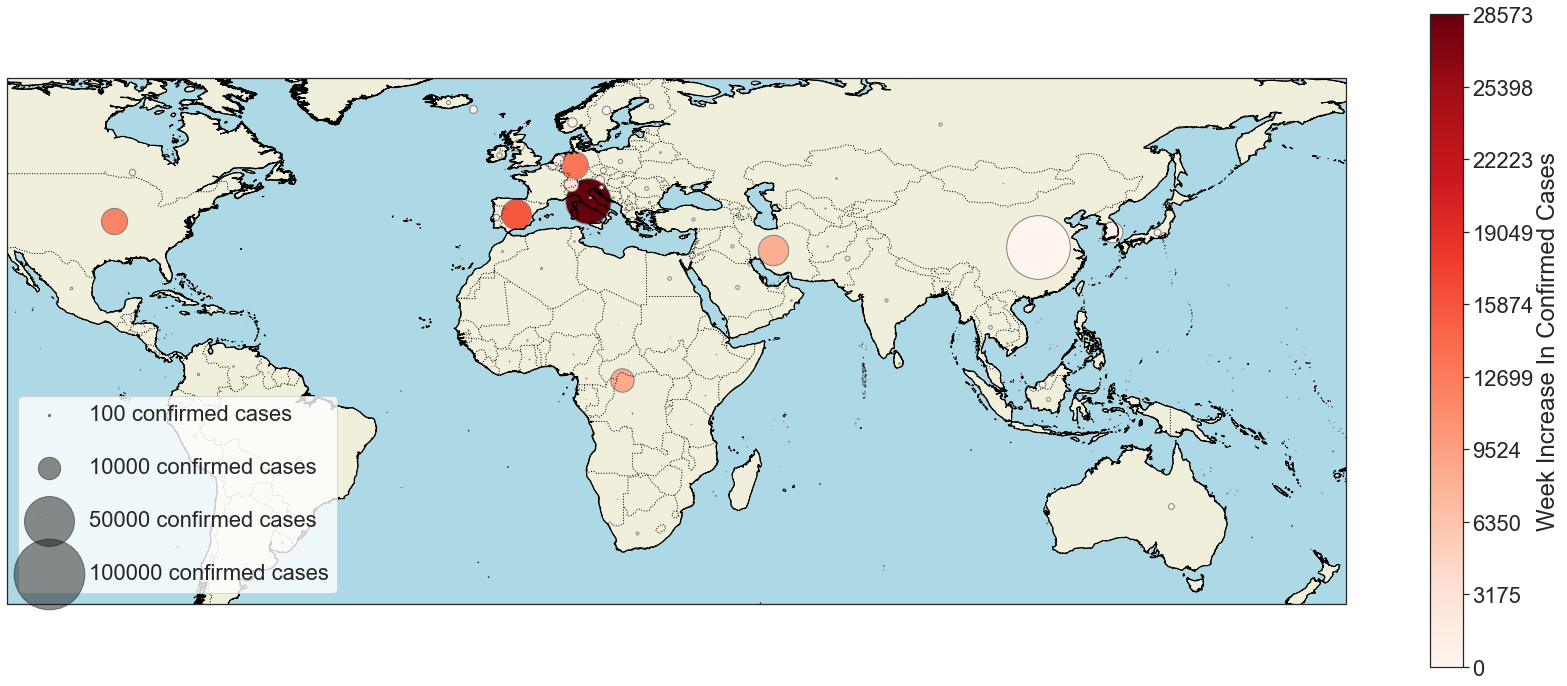

In [33]:
fig = plt.figure(figsize=(30,12))

ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS, linestyle=':', alpha=1)
ax.add_feature(cfeature.OCEAN, facecolor=("lightblue"))
ax.add_feature(cfeature.LAND)
ax.coastlines(resolution='10m')


data_crs = ccrs.PlateCarree()



week_change_list = []
week_confirmed_list = []

for country in covid_cases['confirmed'].columns:
    week_end = most_recent_date
    week_start = most_recent_date - timedelta(days=7)
    week_end_confirmed = covid_cases.loc[week_end, ('confirmed', country)].item()
    week_start_confirmed = covid_cases.loc[week_start, ('confirmed', country)].item()
    week_change_list.append(week_end_confirmed - week_start_confirmed)
    week_confirmed_list.append(week_end_confirmed)

mini, maxi = min(week_change_list), max(week_change_list)
norm=plt.Normalize(mini,maxi)

for country in covid_cases['confirmed'].columns:
    lat, long = coords.loc[country, 'Lat'], coords.loc[country, 'Long']
    week_end = most_recent_date
    week_start = most_recent_date - timedelta(days=7)
    week_end_confirmed = covid_cases.loc[week_end, ('confirmed', country)].item()
    week_start_confirmed = covid_cases.loc[week_start, ('confirmed', country)].item()
    week_change = week_end_confirmed - week_start_confirmed
    ax.scatter(long, lat, transform=data_crs,
              c=week_change, s=(week_end_confirmed/20),
              cmap='Reds', alpha=1, edgecolors='grey',
              norm=norm)
    #ax.text(long, lat, country)
    
sm = plt.cm.ScalarMappable(cmap='Reds', norm=plt.Normalize(vmin=mini, vmax=maxi))
sm._A = []
cb = plt.colorbar(sm, label='Week Increase In Confirmed Cases')
cb.set_ticks(np.linspace(mini, maxi, 10))

# make legend with dummy points
for a in [100, 10000, 50000, 100000]:
    plt.scatter([], [], c='k', alpha=0.5, s=a/20,
                label=str(a) + ' confirmed cases')
plt.legend(scatterpoints=1, frameon=True,
           labelspacing=1.5, loc='lower left')

plt.show()

**Optional: Create a map to visualise the results of your 'mitigation' analysis (fourth question of the previous section).**

### 6. Concluding remarks